In [1]:
cd ..

/Users/yanndubois/SSL-Risk-Decomposition


In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Collect all results

In [3]:
import torch
import pandas as pd
from utils.plotting import *
from utils.collect_results import *
from utils.causal import *
import numpy as np
import warnings
import logging
import hubconf

 No module named 'clip'


In [4]:
is_subset=False
is_read_files=True
if is_subset:
    DATA = "imagenet-S0.01"
    subset = 0.01
    base_pred = 'sk_logistic_hypopt'
    threshold_kwargs=dict(threshold_bad_ifnew=70,
                           threshold_delta=100 # don't use
                          )
else:
    DATA = "imagenet"
    subset = None
    base_pred = 'torch_linear_hypopt'
    threshold_kwargs=dict()
    

metadata_df = hubconf.metadata_df(is_multiindex=False)

if is_read_files:
    results = load_all_results(pattern=f"**/data_{DATA}/**/*hypopt*/**/results_all.csv",
                               skip_ifneq=dict(data=DATA.lower(), pred=base_pred))
    check_missing(results, metadata_df)
    results = format_approx_results(results, metadata_df, f_replace_arch=f_replace_arch, subset=subset)
    results = make_risk_decomposition(results, traverse_path=["down","right","down"], is_print=True, subset=subset)
    results, metadata_df = clean_results(results, metadata_df, predictor=base_pred)
    validate_results(results, metadata_df, **threshold_kwargs)

    # filter out values that are suspiciously bad
    to_del = ["selav2_rn50_ep400_2x160_4x96"]
    to_keep = [i for i in results.index.get_level_values("enc") if i not in to_del]
    results = results.loc[to_keep]

    results.to_csv(f"notebooks/saved/results_{DATA}_{base_pred}.csv")
else:
    results=pd.read_csv(f"notebooks/saved/results_{DATA}_{base_pred}.csv",index_col=0)
    
    
metadata_df = metadata_df.loc[to_keep]
df = pd.concat([results,metadata_df], axis=1)
df = df.replace(dict(ssl_mode={"hierarchical contrastive": "hierarchical"}))

# coarsens many different parameters for cleaner plots
df = preprocess_features(df, round_dict={}, pow_dict={})

melted = melt(df)

Found 306 result files to load.


Found missing supervised models for:


,pred,seed,arch
0,torch_linear_hypopt,123,vitl7 cls
1,torch_linear_hypopt,123,vitb4 cls
2,torch_linear_hypopt,123,resnet50w64
3,torch_linear_hypopt,123,resnet50w16
4,torch_linear_hypopt,123,resnet50w4
5,torch_linear_hypopt,123,resnet50w4
6,torch_linear_hypopt,123,resnet50w4
7,torch_linear_hypopt,123,vith14 cls
8,torch_linear_hypopt,123,vits8 cls


[usability] = [train_train] - [sup_train_train]
[probe_gen] = [train-cmplmnt-ntest_train-sbst-ntest] - [train_train]
[enc_gen] = [train_test] - [train-cmplmnt-ntest_train-sbst-ntest]


Found negative values:


,usability,enc_gen,probe_gen,approx,agg_risk
enc,,,,,
dissl_resnet50_d8192_e400_m6,-5.419,3.060,19.441,10.507,27.588
dissl_resnet50_d8192_e800_m8,-5.806,3.382,19.179,10.507,27.262
selav2_rn50_ep400_2x160_4x96,89.392,0.002,-0.001,10.507,99.900
swav_rn50_ep100,-0.382,3.328,17.109,10.507,30.562


The following results seem suspicously bad:


,agg_risk
enc,
beit_vitb16_pt22k,55.357999
selav2_rn50_ep400_2x160_4x96,99.900001


The following models have very different original and evalauted performance:


enc
deepcluster_rn50_bs512_ep200_mmselfsup   -16.153999
jigsaw_rn50                               10.626001
jigsaw_rn50_in22k                         13.222003
selav2_rn50_ep400_2x160_4x96              71.700001
dtype: float64

The following results have some nan:


,usability,enc_gen,probe_gen,approx,agg_risk
enc,,,,,
clip_rn50x16,NaN,2.202,2.078,NaN,19.444
clip_rn50x4,NaN,2.190,2.651,NaN,22.316
clip_rn50x64,NaN,2.014,2.328,NaN,16.998
dino_vits8_last,NaN,3.296,3.410,NaN,21.328
mae_vith14,NaN,3.648,5.624,NaN,24.190
msn_vitb4_ep300,NaN,5.662,5.469,NaN,20.740
msn_vitl7_ep200,NaN,4.336,1.677,NaN,19.320
simclr_rn50w4,NaN,3.618,14.748,NaN,28.894
swav_rn50w4,NaN,3.492,14.467,NaN,23.584


In [5]:
#non_core_params = ['date_published','top1acc_in1k_official','projection_nparameters']
core_params = ['objective','version','architecture','patch_size','z_dim','z_layer',
               "epochs","batch_size", "optimizer", "learning_rate", "weight_decay", "scheduler",
               "pretraining_data",'img_size','year',"nviews",'finetuning_data','projection_arch']
minimal_params = ['objective','version','architecture','patch_size','z_dim','z_layer',"pretraining_data",'finetuning_data']
df_core = df.set_index(core_params)[results.columns]
df_minimal = df.set_index(minimal_params)[results.columns]
melted_onlyComp = melt(df, components=COMPONENTS_ONLY)


### Examples of models
Let's plot a few models as comparison. Only plot the ones that do not have any nans

! once you have all the results you might want to replace resnet -> rn and mmselfsup -> mmss to gain space

In [6]:
from IPython.display import IFrame,display

is_plot_radar = False
save_path="figures/all_radar.pdf"

if is_plot_radar:
    isna = df[COMPONENTS].isna().any(axis=1)
    plot_radar_grid(df, ncols=7, components=["agg_risk"]+COMPONENTS_ONLY, models=~isna, save_path=save_path, 
                    config_kwargs=dict(font_scale=1, is_despine=False))
else:
    out = IFrame(Path("..") / save_path, width=1000, height=500)
    display(out)

### Effect over time
Let's see how each components changed over time. We will aggregate per year as a rough estimate.

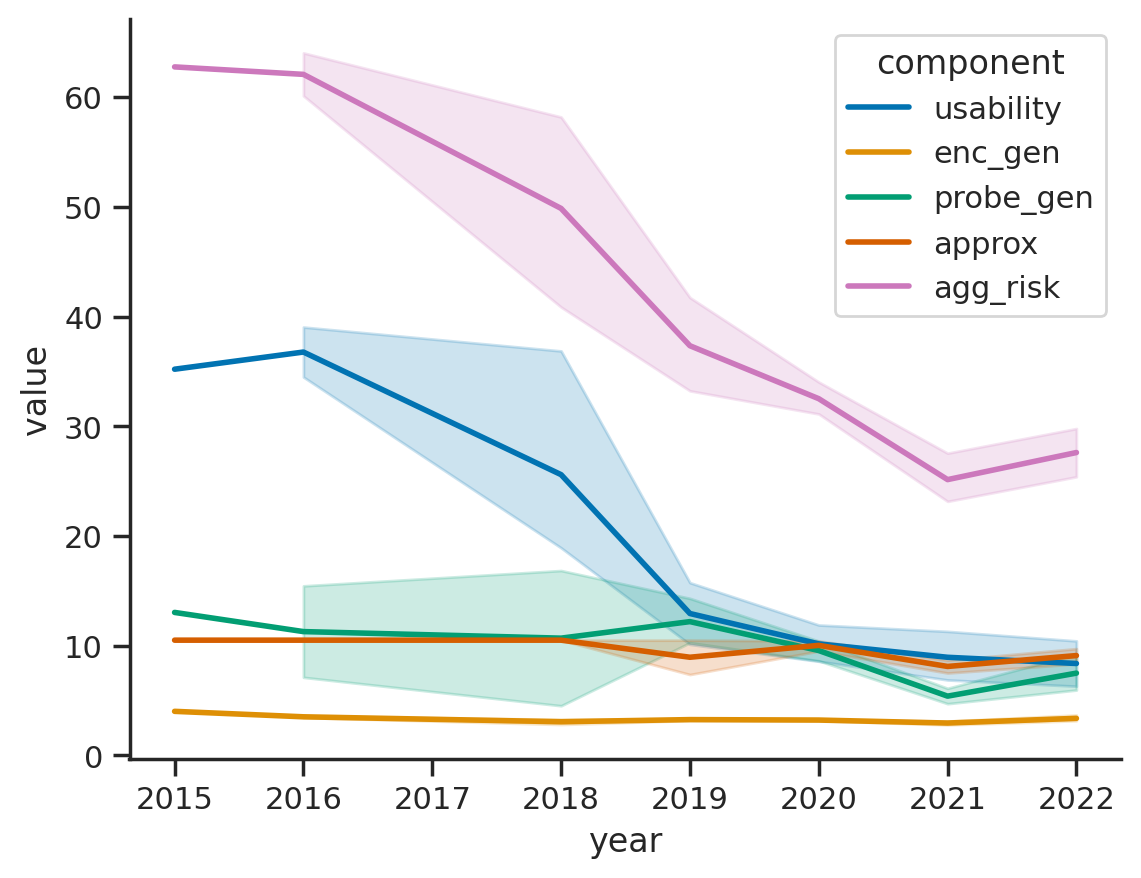

In [7]:
with plot_config(font_scale=1):
    sns.lineplot(data=melted, x="year", y="value", hue="component")

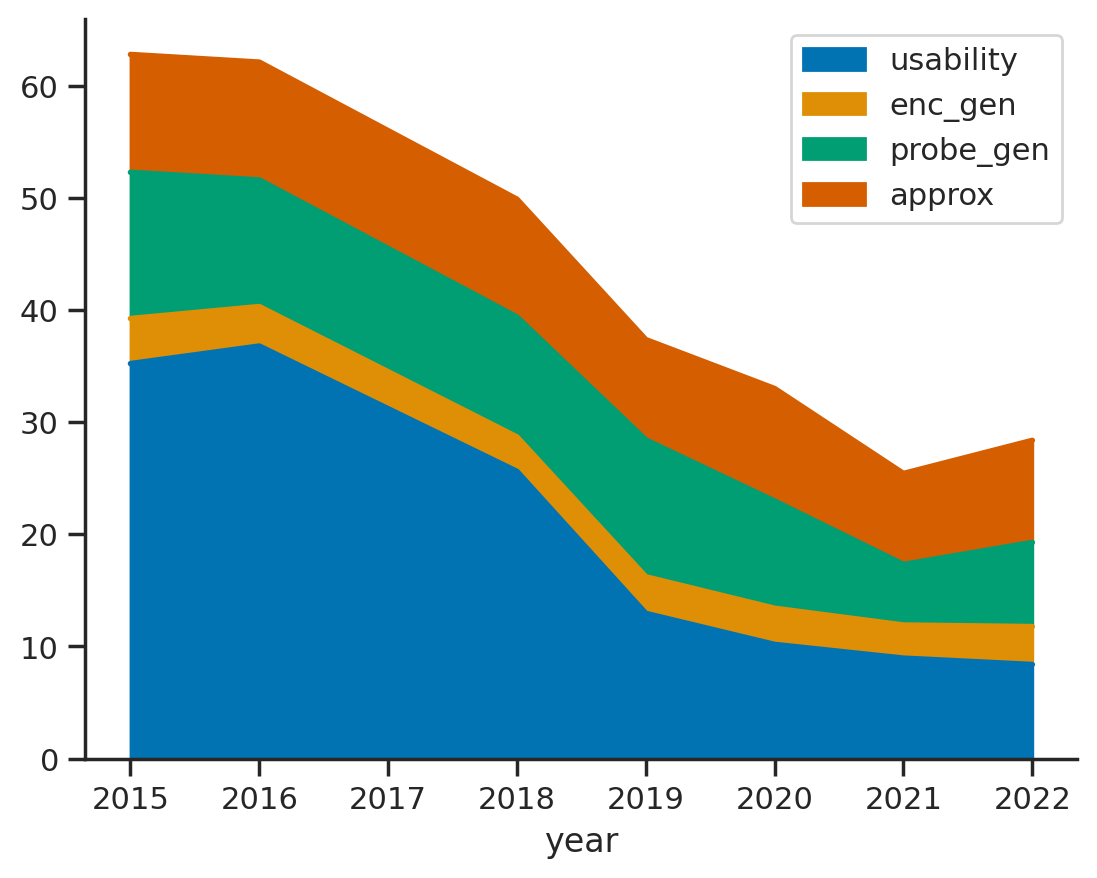

In [8]:
with plot_config(font_scale=1):
    curr_df = df.copy()[COMPONENTS_ONLY + ["year"]]
    curr_df.groupby("year").mean().plot.area()

We see that most of the gains over time have been hapening in usability, while the oters haven't changed much. We are now at the point were usability ~= probe gen ~= approx error. We also see that the generalization error is really not a problem at this scale. Note that it might be surprising to see that the probe doesn't generalize so well despite having hundred of thousands of training points and being only linear. 

Now let's consider models that have the same objectives but have changed over time (hparam tuning) as different version. 

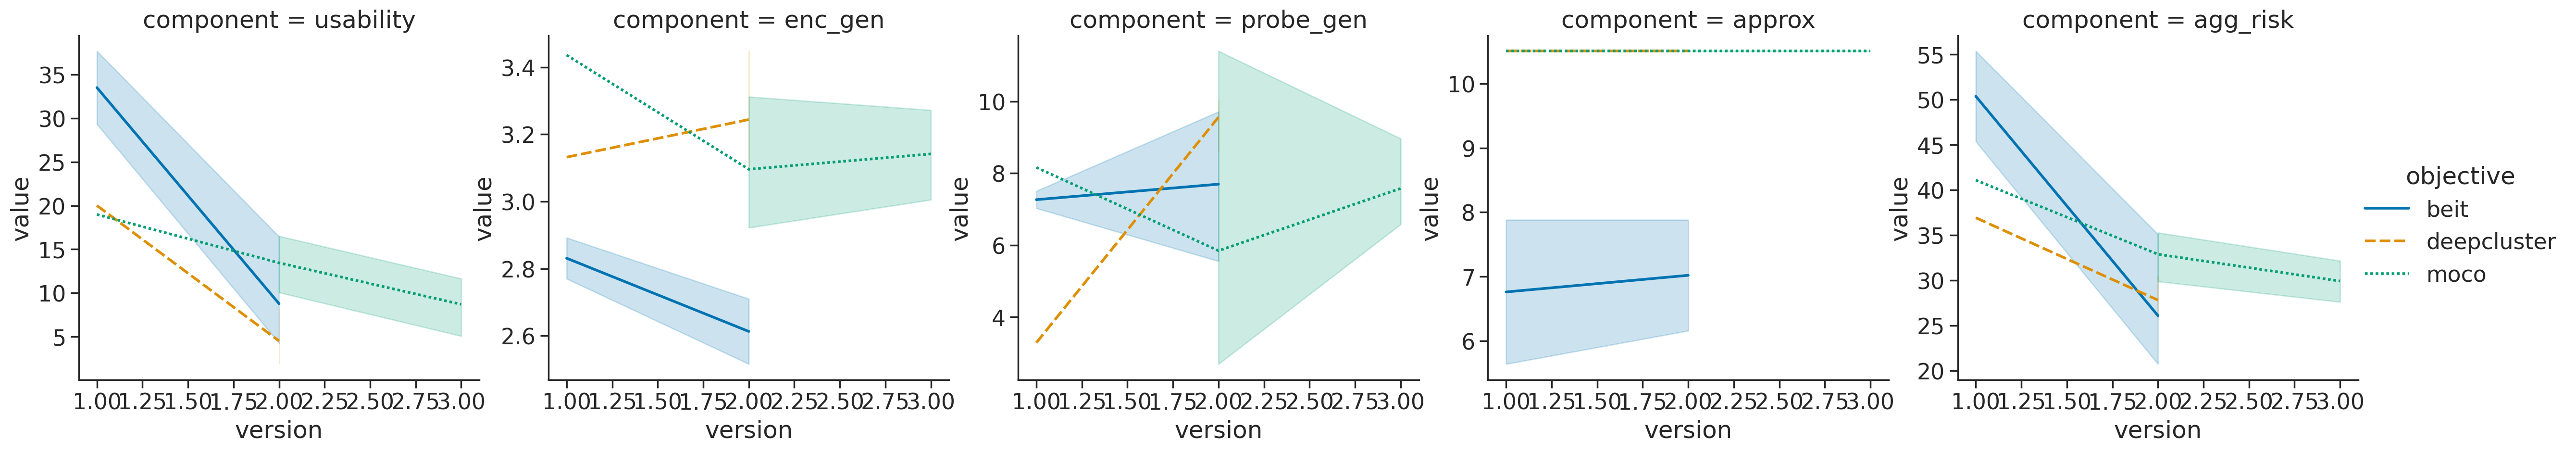

In [9]:
with plot_config():
    df_version = melt(get_only_vary(df, ["version"], ["objective","version","architecture"]))

    sns.relplot(data=df_version, 
                x="version", 
                y="value", 
                hue="objective",
                style="objective",
               col="component",
               kind="line",
                facet_kws={'sharey': False}, 
                #err_style="bars"
               )

We see again that in the three cases usability has been the main driver of progress.


### Effect of type of method

Now let's consider the effect of the type of method

**Hypothesis** ISSL showed that contrastive, distillation and clustering all optimize nearly the right objective and can be made correct with minor differences, so we hypothesize that usability for them must be good.

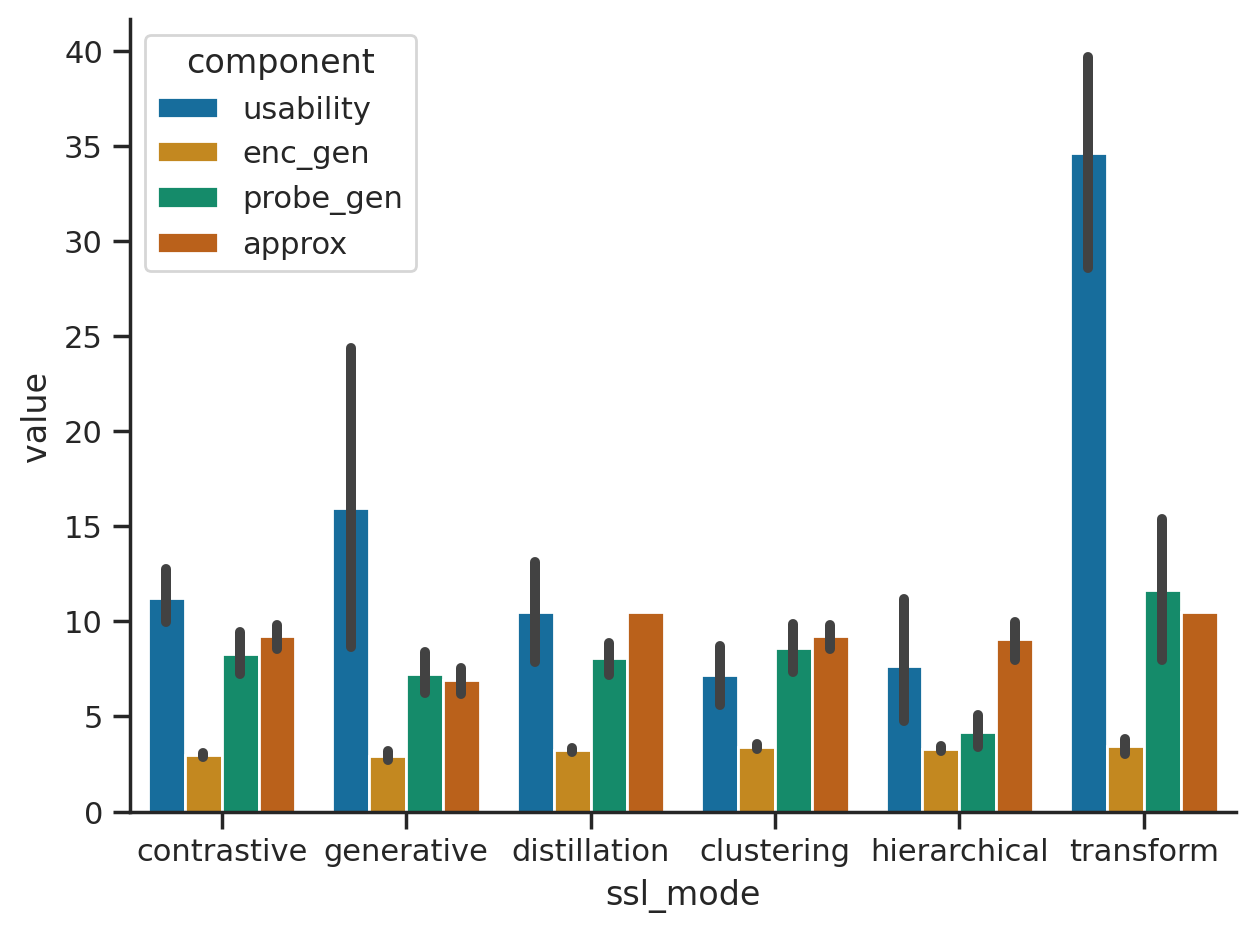

In [10]:
with plot_config(font_scale=1):
    sns.barplot(data=melted_onlyComp, x="ssl_mode", y="value", hue="component")
    plt.tight_layout()

It seems that the ssl mode mostly has an impact on the usability component with transform and generative being very bad. 

## Naive plots
The following are naive plots where we plot everything without thinking about confounders. As a result they are likely meaningless for interpretaition but should rather be used as ways to understand our data.

### Effect of epochs

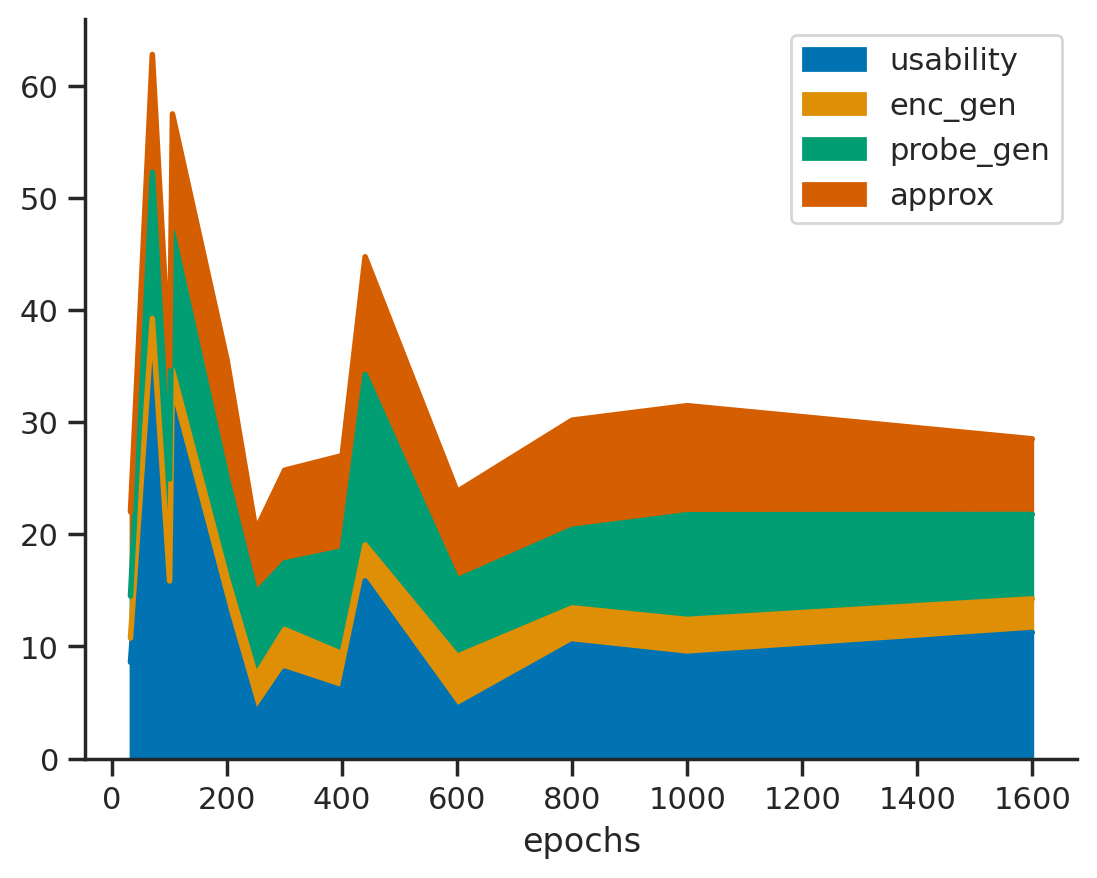

In [11]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["epochs"]])
    curr_df.groupby("epochs").mean().plot.area()

Doesn't show much

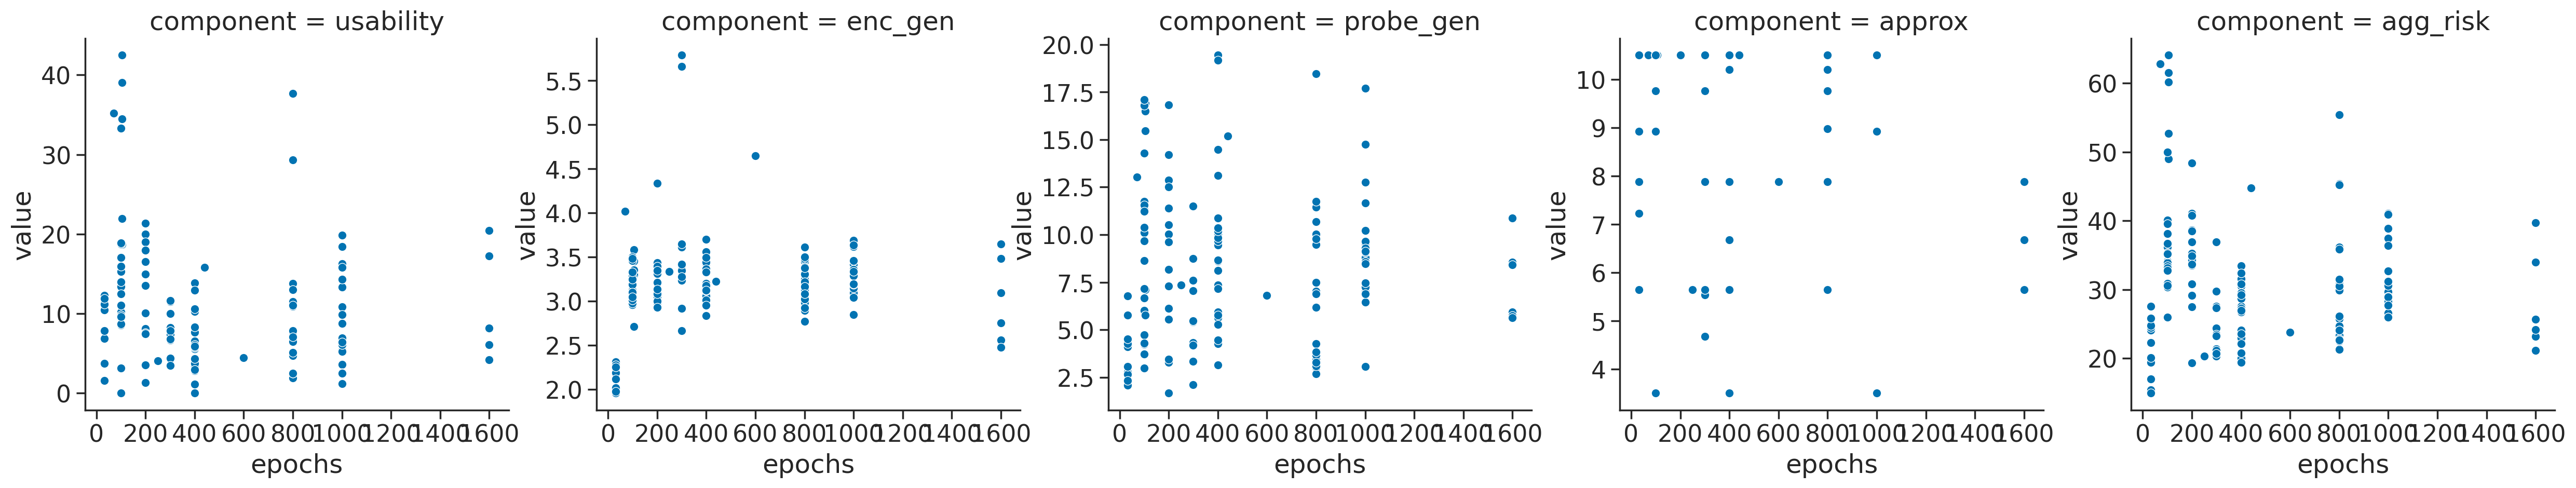

In [12]:
with plot_config():
    sns.relplot(data=melted, x="epochs", y="value", col="component", facet_kws={'sharey': False})

### Effect of batch size

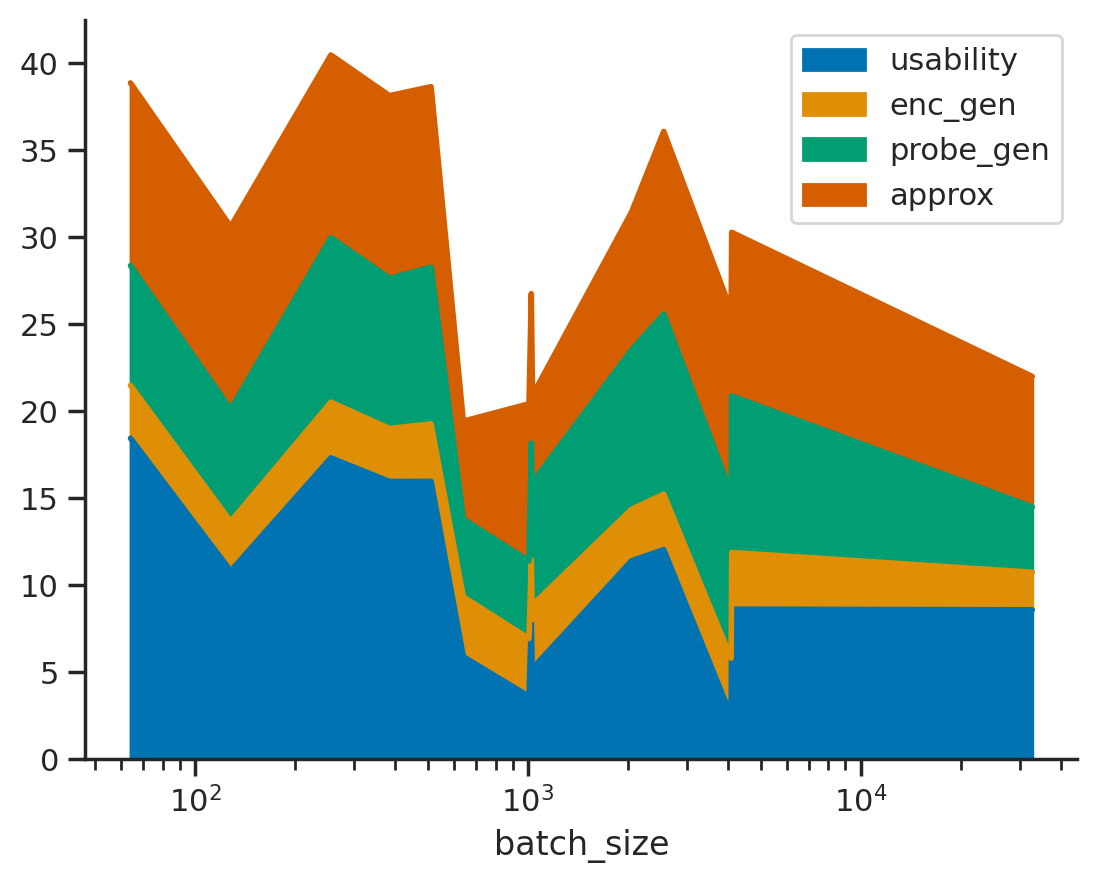

In [13]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["batch_size"]])
    curr_df.groupby("batch_size").mean().plot.area(logx=True)

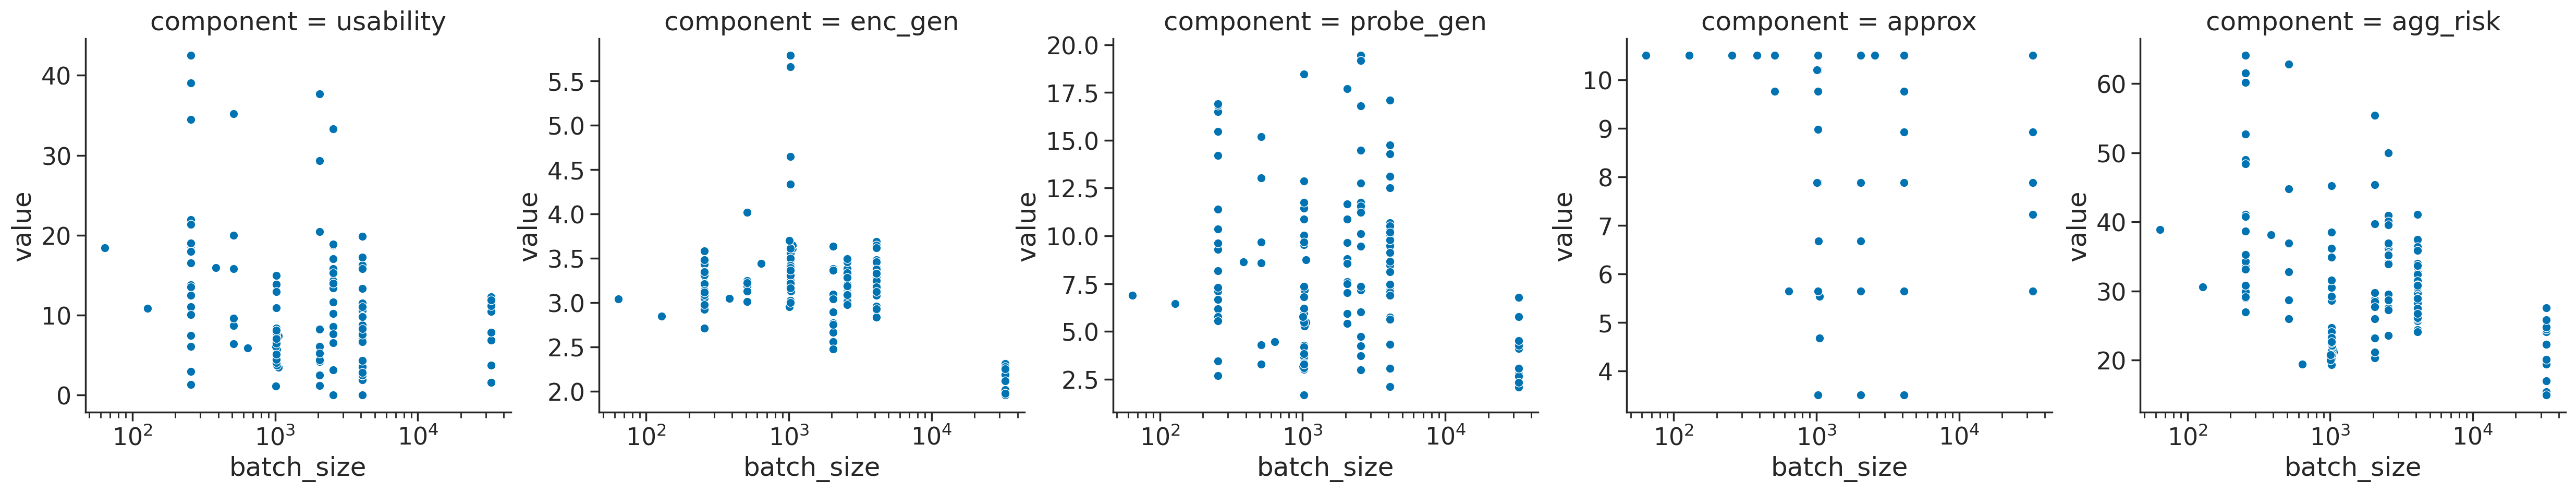

In [14]:
with plot_config():
    g=sns.relplot(data=melted, x="batch_size", y="value", col="component", facet_kws={'sharey': False})
    g.set(xscale="log")

### Effect of multicrops

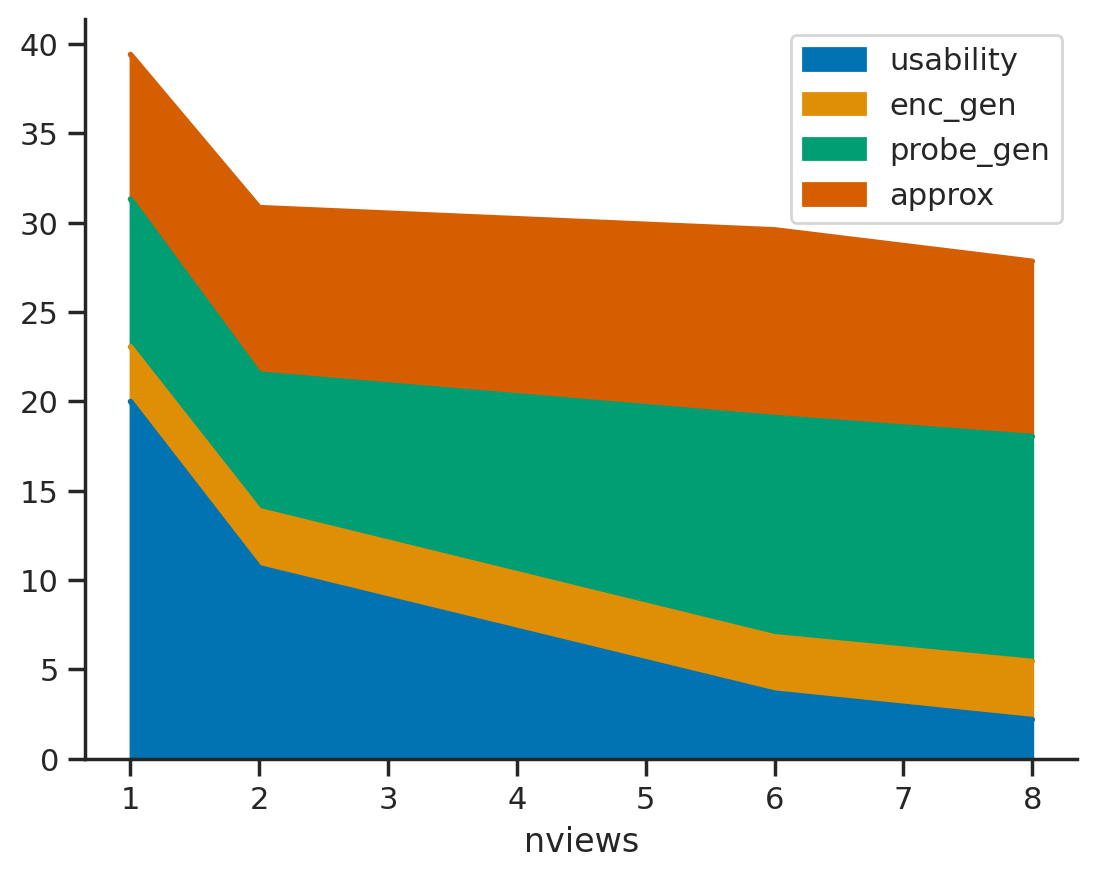

In [15]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["nviews"]])
    curr_df.groupby("nviews").mean().plot.area()

We see that nviews seems to have a huge effect on usability but detrimental effect on probing generalization. That being said there is probably a big confounder as few models (and usually more recent) use multicrops.

### Effect of dimensionality

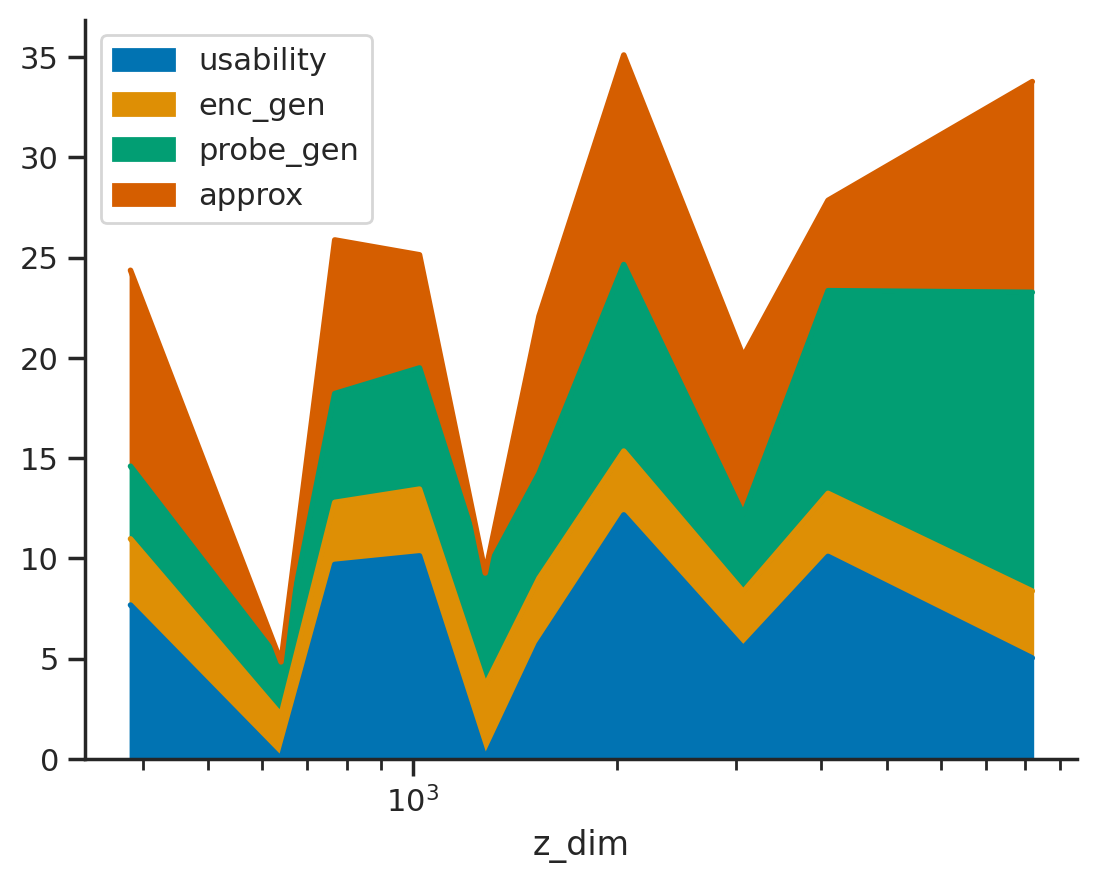

In [16]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["z_dim"]])
    curr_df.groupby("z_dim").mean().plot.area(logx=True)

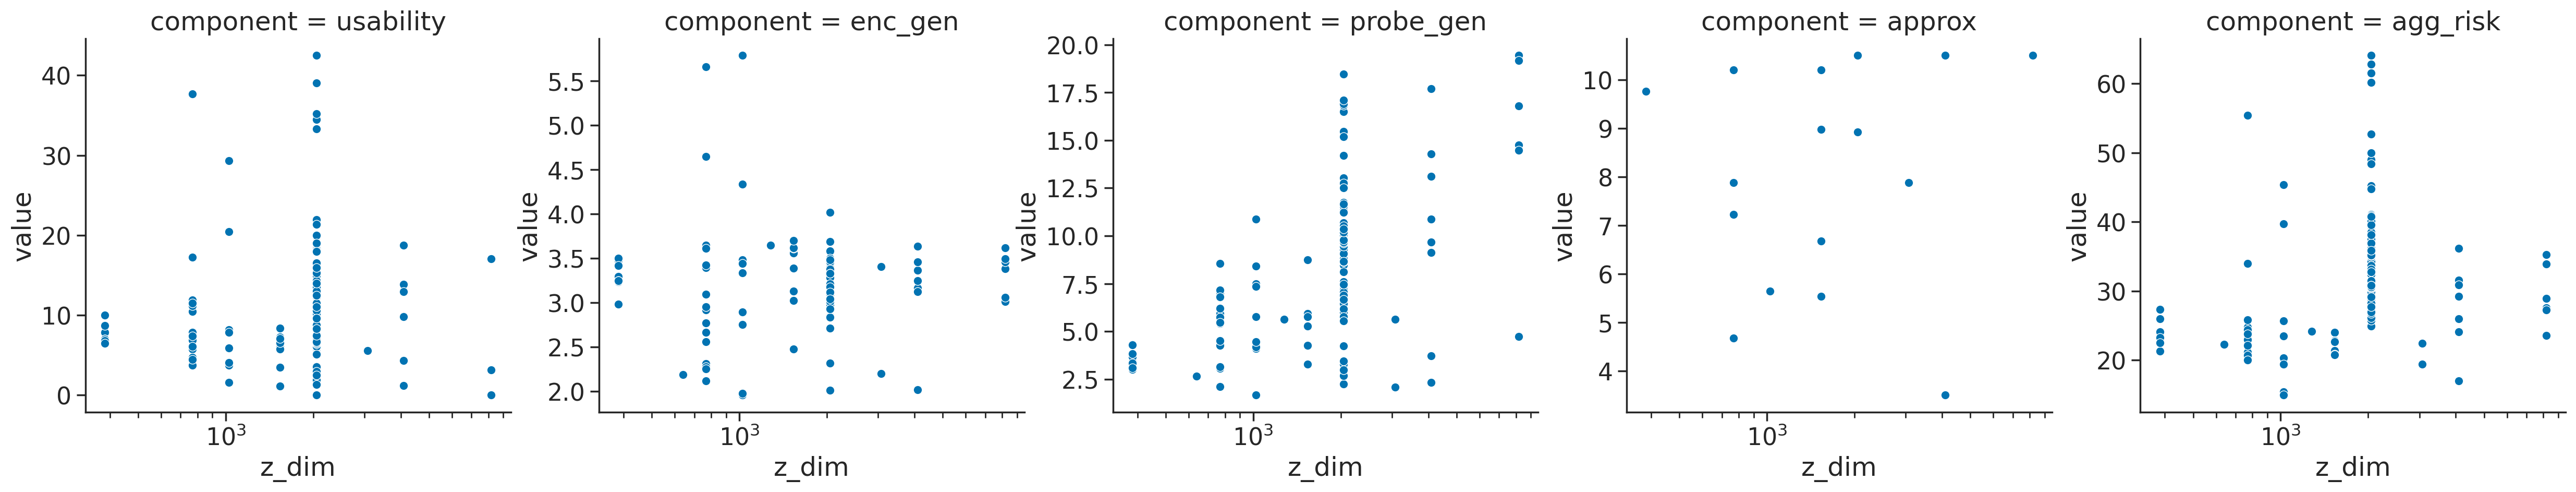

In [17]:
with plot_config():
    g=sns.relplot(data=melted, x="z_dim", y="value", col="component", facet_kws={'sharey': False})
    g.set(xscale="log")

### Effect of architecture

#### N parameters

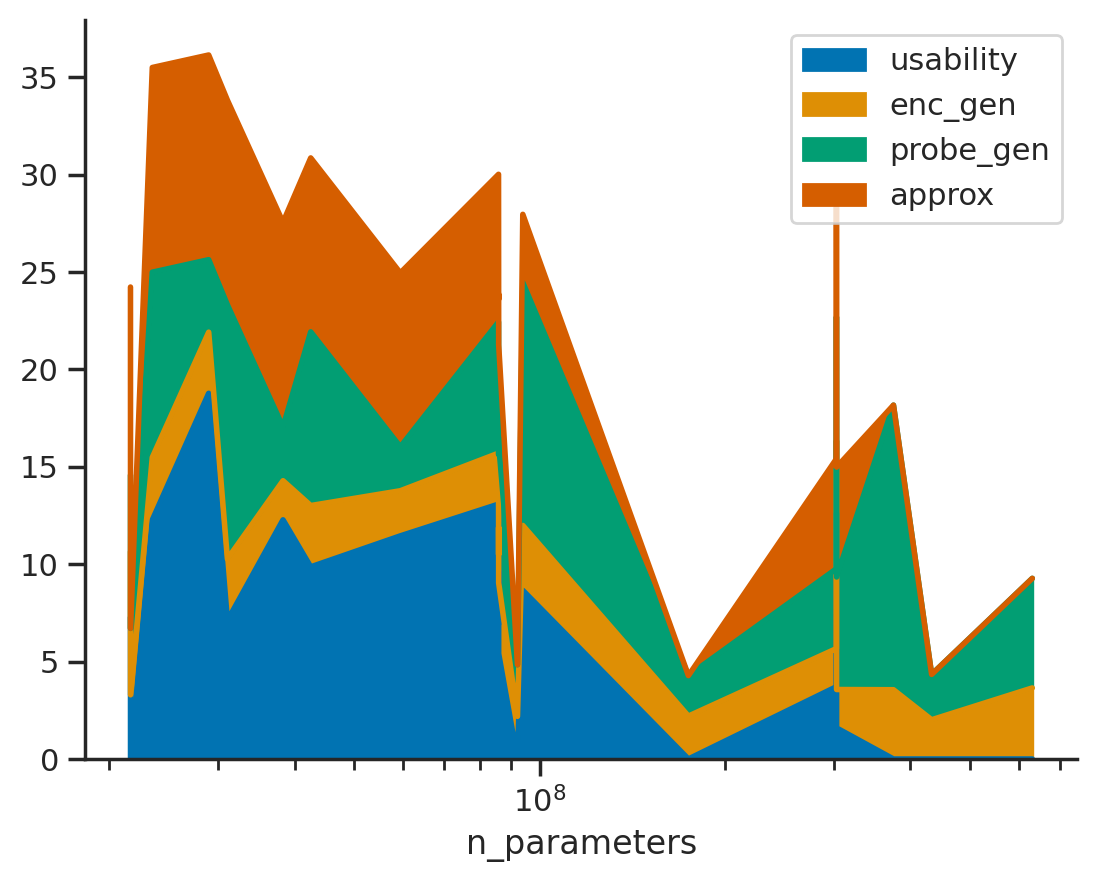

In [18]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["n_parameters"]])
    curr_df.groupby("n_parameters").mean().plot.area(logx=True)

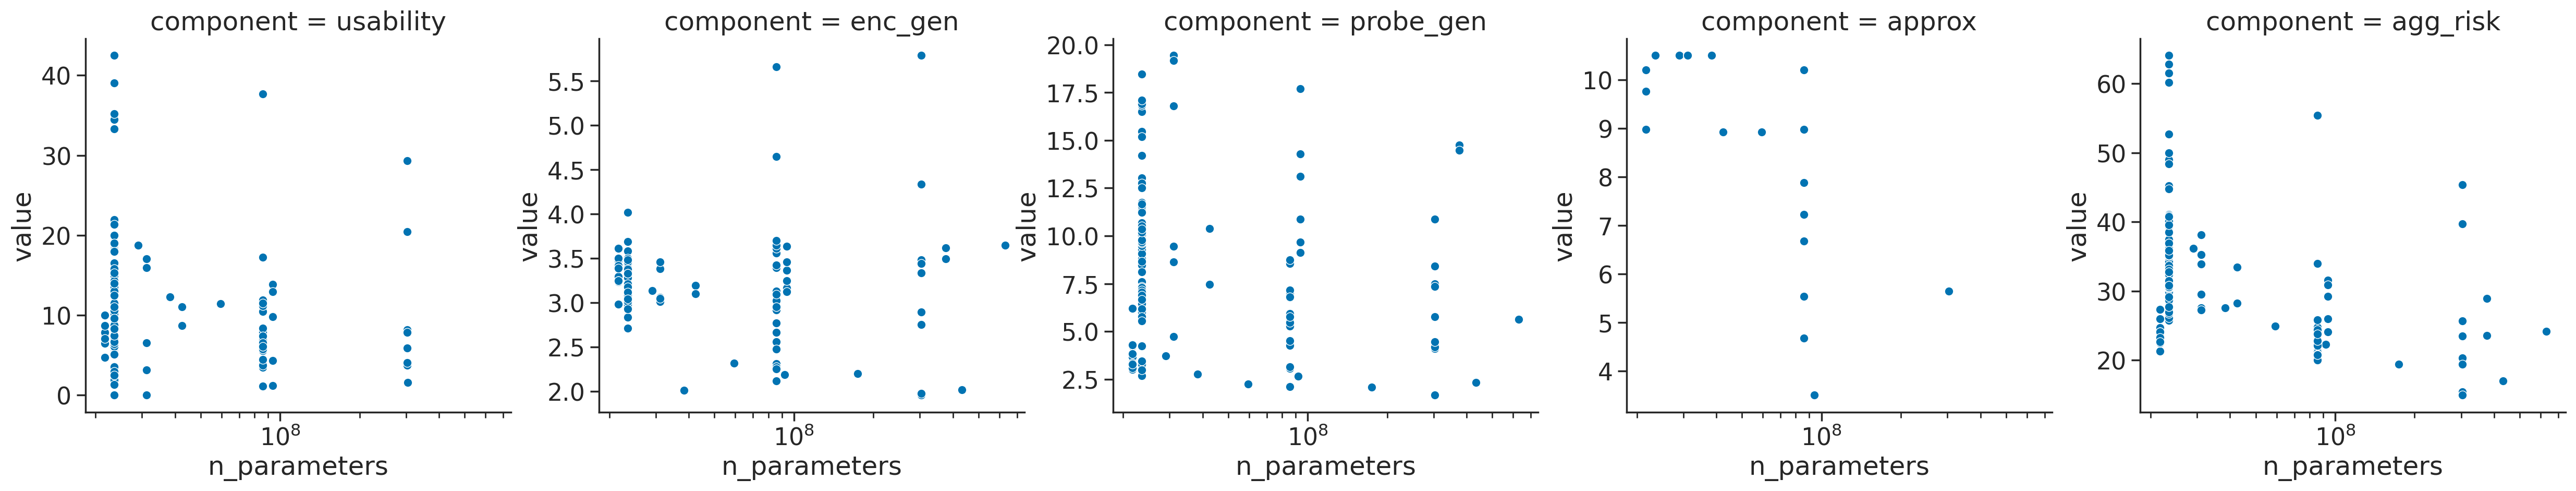

In [19]:
with plot_config():
    g=sns.relplot(data=melted, x="n_parameters", y="value", col="component", facet_kws={'sharey': False})
    g.set(xscale="log")

#### ViT vs ResNet

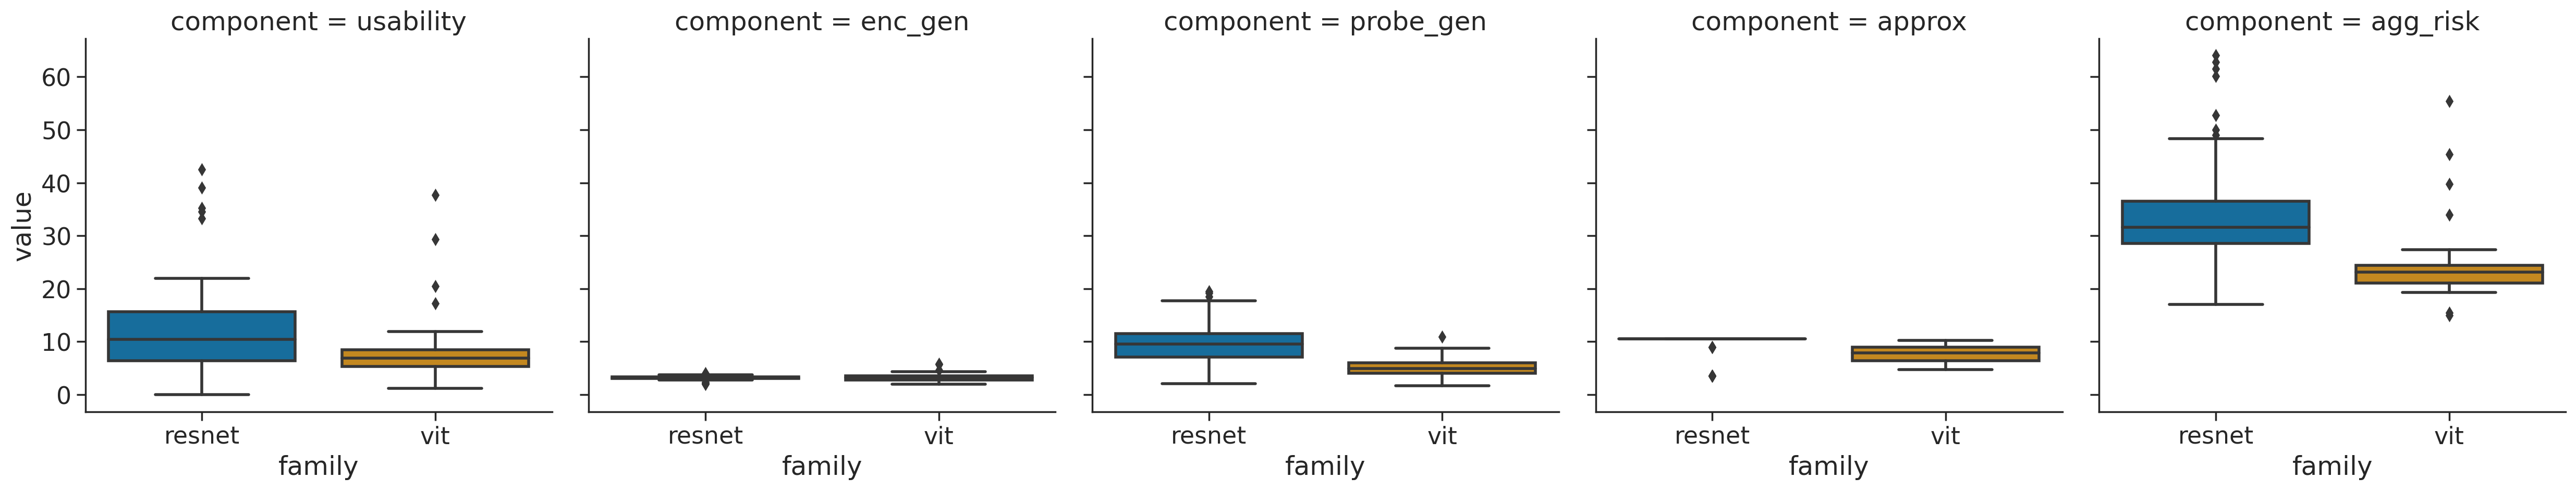

In [20]:
with plot_config():
    g=sns.catplot(data=melted, x="family", y="value", col="component", facet_kws={'sharey': False}, kind="box")
#g.set(xscale="log")

Appproximation gap seems slightly better.

#### Effect of patch size

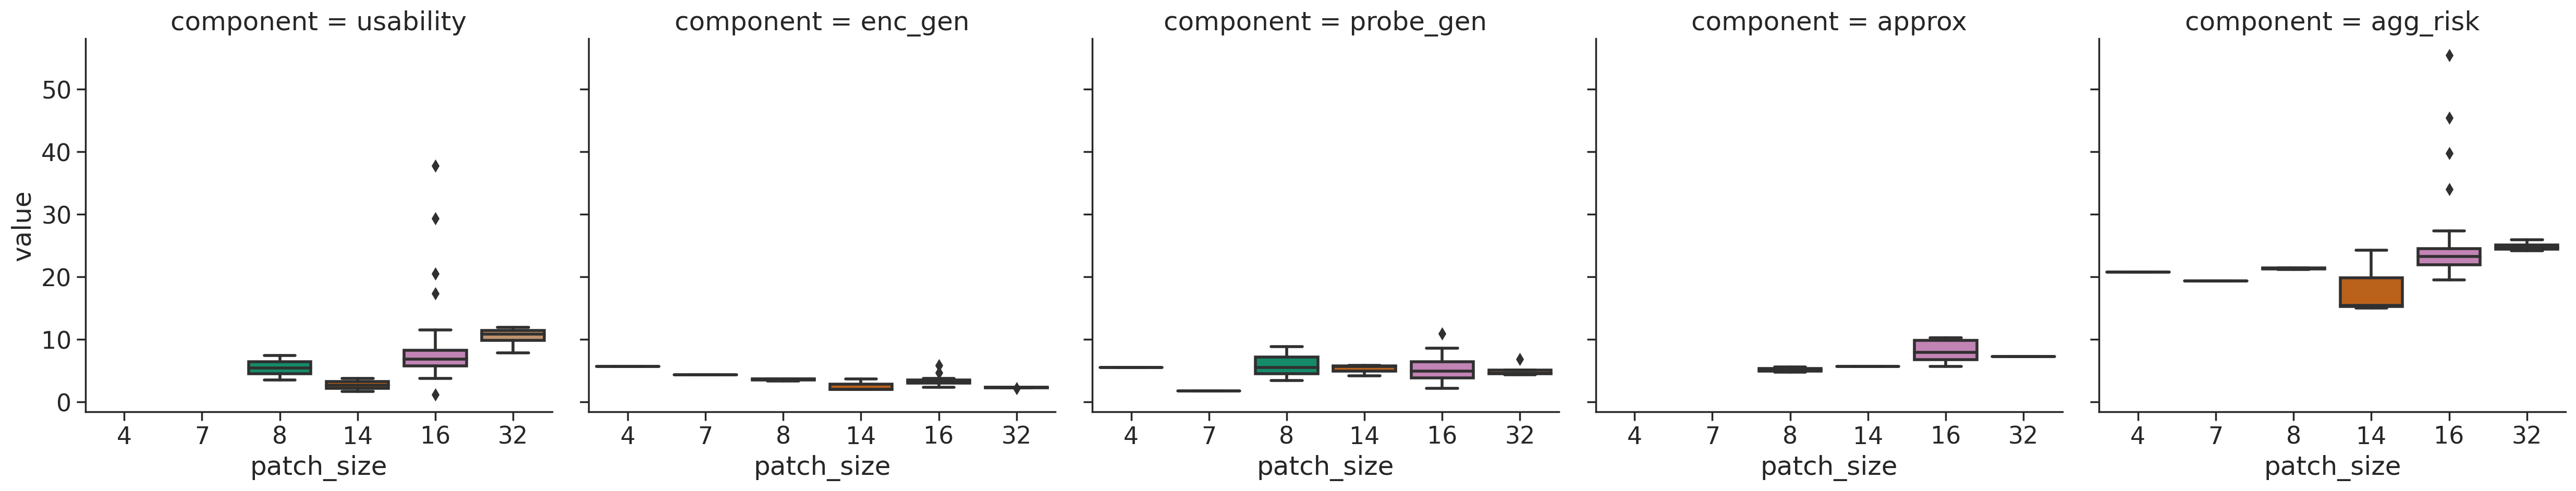

In [21]:
with plot_config():
    g=sns.catplot(data=melted[melted.family=="vit"], 
              x="patch_size", y="value", col="component", facet_kws={'sharey': False}, kind="box")
#g.set(xscale="log")

Larger patch size is worst approx

### Effect of projection 

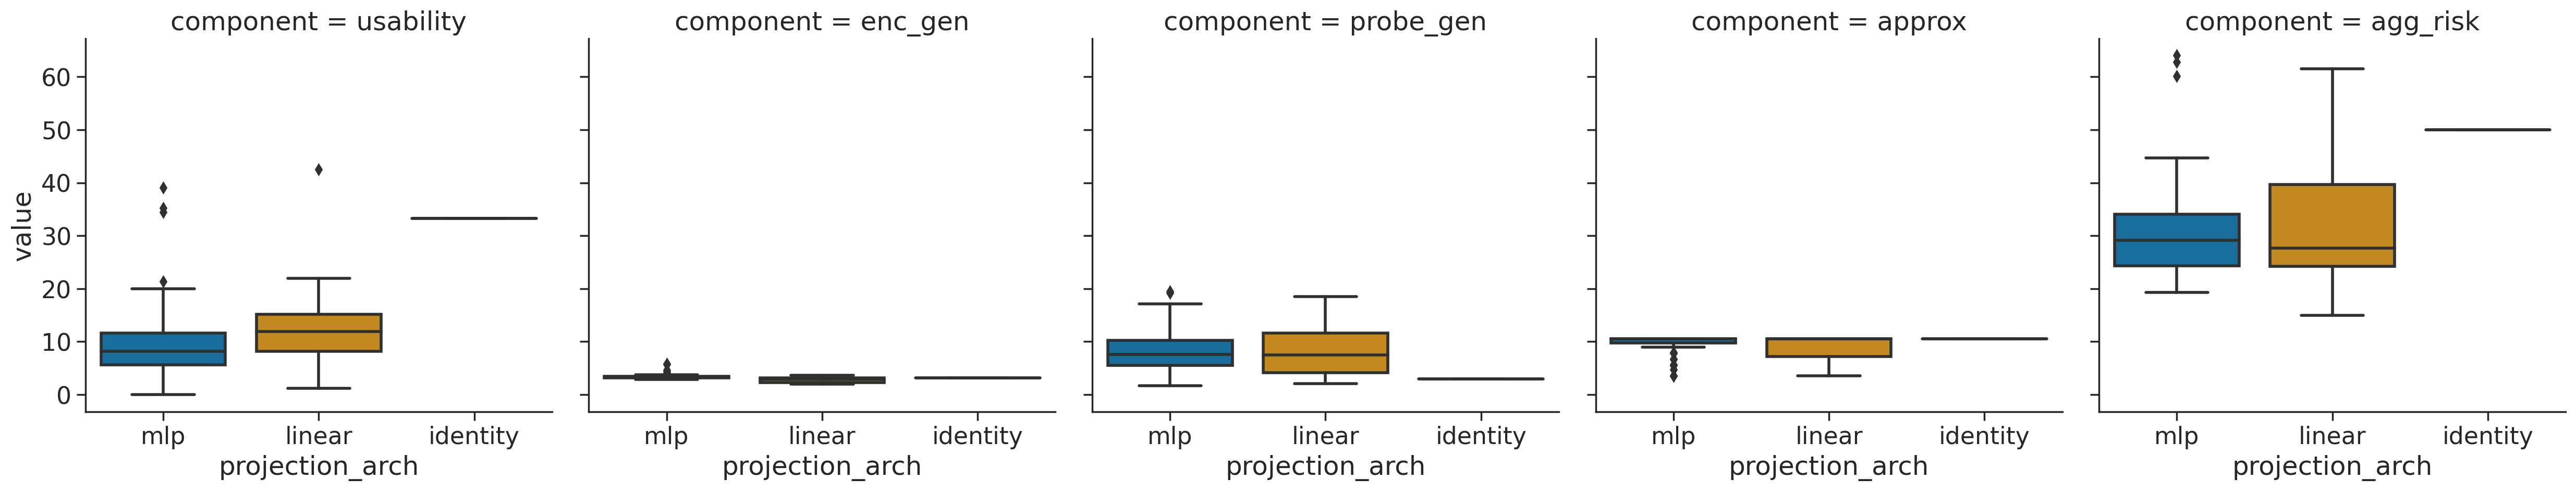

In [22]:
with plot_config():
    g=sns.catplot(data=melted, x="projection_arch", y="value", col="component", facet_kws={'sharey': False}, kind="box")
#g.set(xscale="log")

### Effect of pretraining data

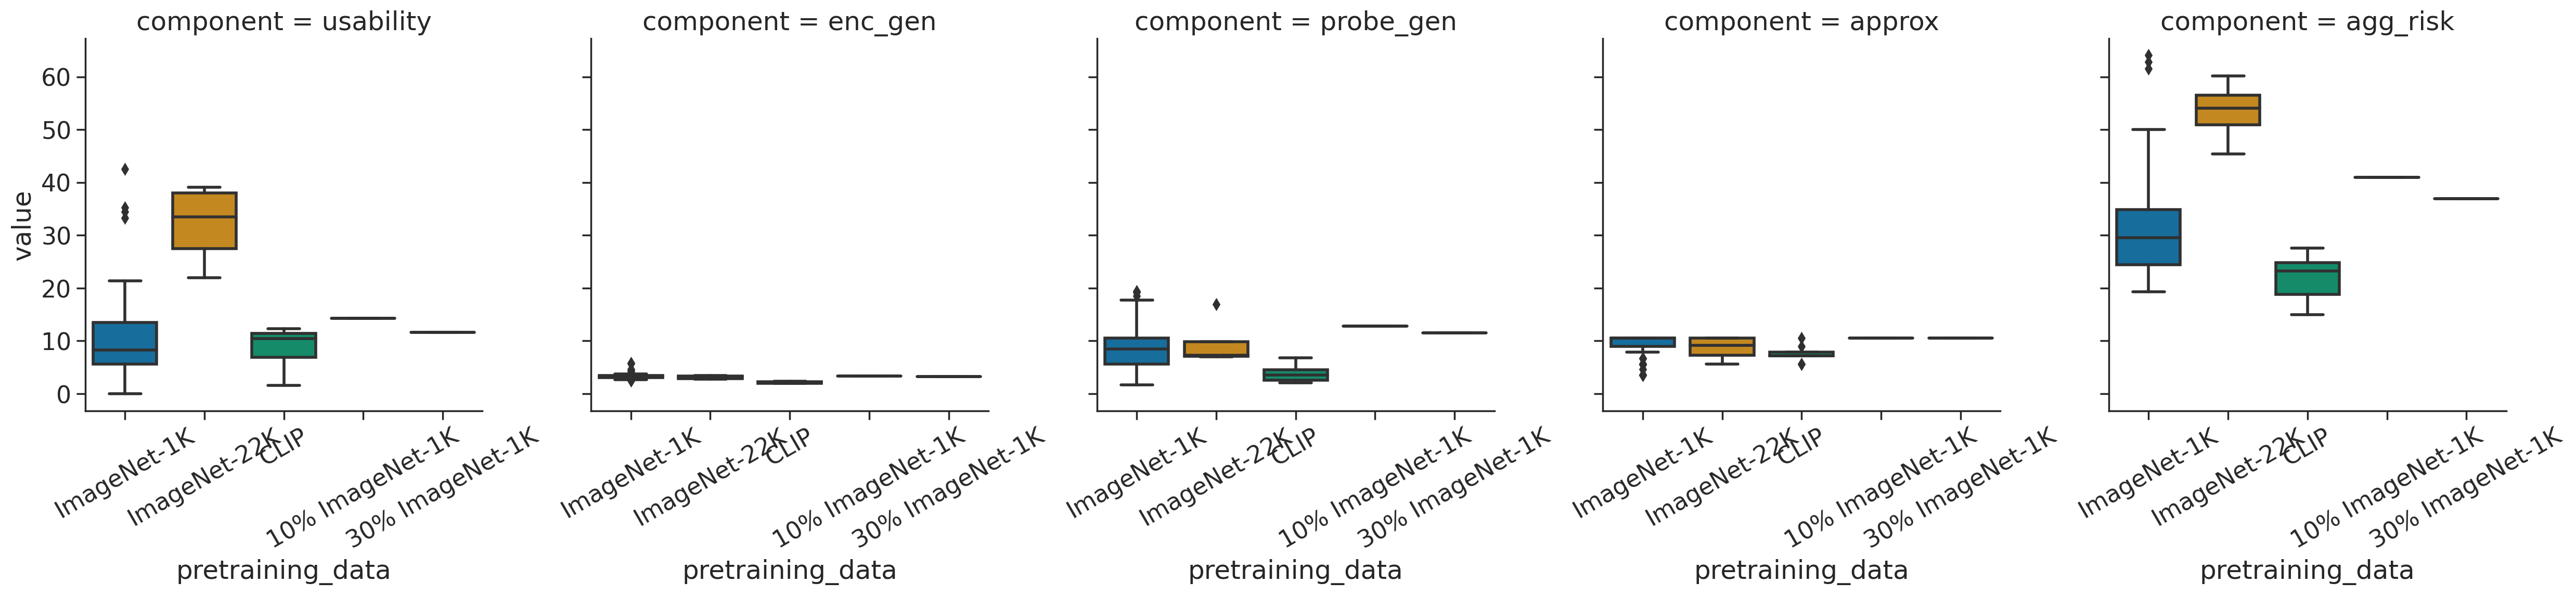

In [23]:
with plot_config():
    g=sns.catplot(data=melted, x="pretraining_data", y="value", col="component", facet_kws={'sharey': False}, kind="box")
    g.set_xticklabels(rotation=30)

### Effect of finetuning

In [24]:
curr_df = df.copy()
curr_df["is_finetuned"] = curr_df.finetuning_data.isna()

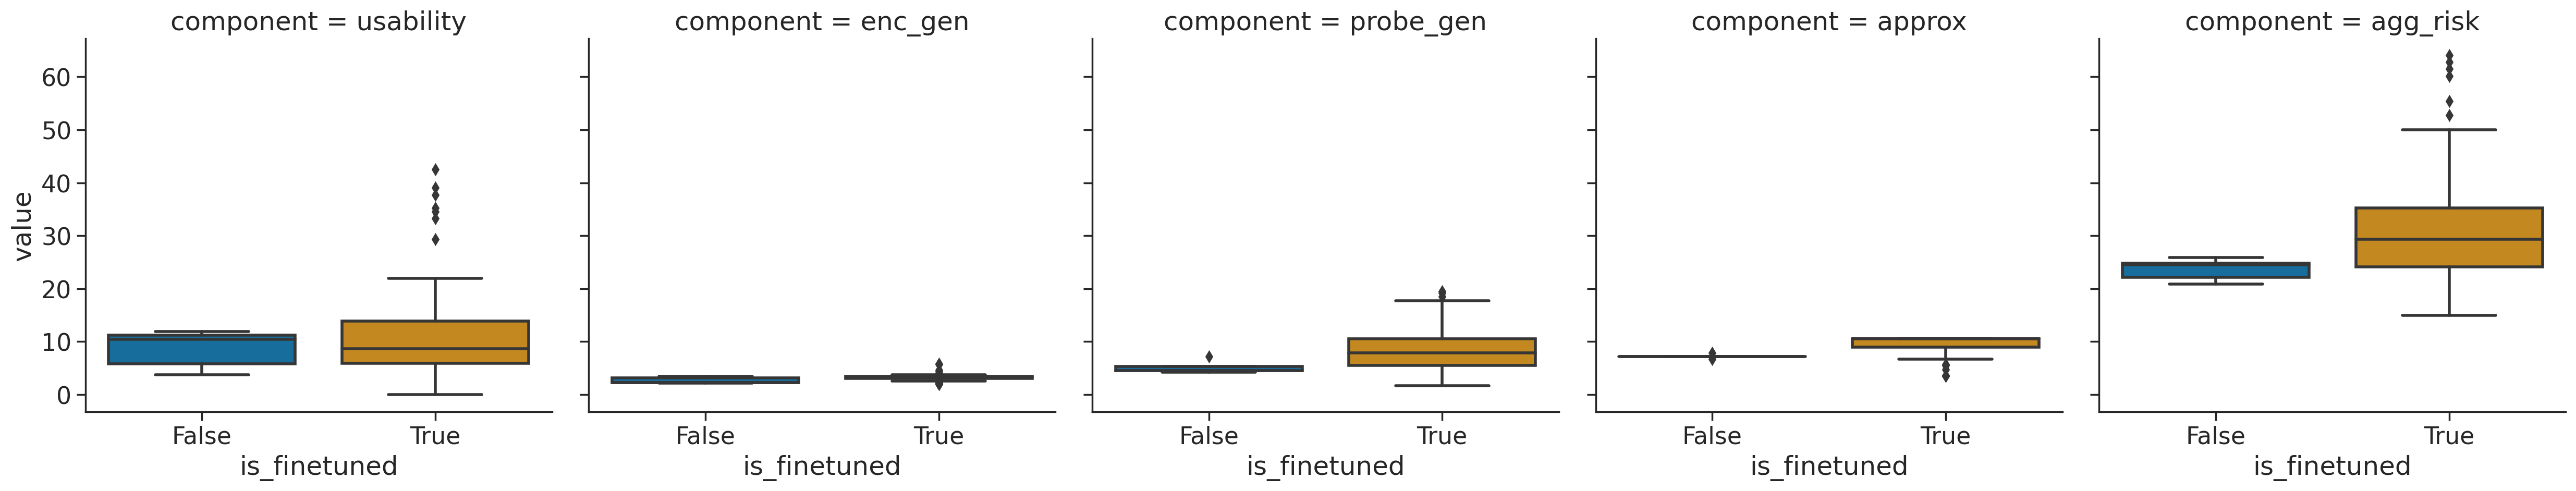

In [25]:
with plot_config():
    g=sns.catplot(data=melt(curr_df), x="is_finetuned", y="value", col="component", facet_kws={'sharey': False}, kind="box")
#g.set(xscale="log")